<a href="https://colab.research.google.com/github/saieshamittal/Anti-Spoofing-Detector1/blob/main/ANTI_SPOOFING_DETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install cvzone
!pip install opencv-python-headless
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 865.2 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

LOADING DATASET FROM OUR GITHUB REPO

In [ ]:
!git clone --depth 1 --filter=blob:none --sparse https://github.com/Shreya-singh01/Anti-Spoofing-Detector.git
%cd Anti-Spoofing-Detector
!git sparse-checkout set collected_images

Cloning into 'Anti-Spoofing-Detector'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 0), reused 23 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 213.99 KiB | 30.57 MiB/s, done.
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 2 (delta 0), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2/2), 481.98 KiB | 26.78 MiB/s, done.
/content/Anti-Spoofing-Detector
remote: Enumerating objects: 8536, done.
remote: Counting objects: 100% (8536/8536), done.
remote: Compressing objects: 100% (8536/8536), done.
remote: Total 8536 (delta 0), reused 8536 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8536/8536), 46.76 MiB | 11.89 MiB/s, done.
Updating files: 100% (8743/8743), done.


IMPORTING LIBRARIES

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
from io import BytesIO

In [ ]:
import matplotlib.pyplot as plt

SPLITTING DATASET INTO TRAIN,TEST AND VAL

In [ ]:
rdir= os.path.join('collected_images', 'real')
fdir = os.path.join('collected_images', 'fake')

splitdr = 'SplitData'
traindr = os.path.join(splitdr, 'train')
valdr = os.path.join(splitdr, 'val')
testdr = os.path.join(splitdr, 'test')

os.makedirs(traindr, exist_ok=True)
os.makedirs(valdr, exist_ok=True)
os.makedirs(testdr, exist_ok=True)

def getallimages(maindr):
    images = []
    for subdir in sorted(os.listdir(maindr)):
        subpath = os.path.join(maindr, subdir)
        if os.path.isdir(subpath):
            images.extend([os.path.join(subpath, f) for f in os.listdir(subpath) if f.endswith('.jpg')])
    return images

rimages = getallimages(rdir)
fimages = getallimages(fdir)

rtrain, rvaltest = train_test_split(rimages, test_size=0.3, random_state=42)
rval, rtest = train_test_split(rvaltest, test_size=0.5, random_state=42)

ftrain, fvaltest = train_test_split(fimages, test_size=0.3, random_state=42)
fval, ftest = train_test_split(fvaltest, test_size=0.5, random_state=42)

def savesplit(images, directory, label):
    labeldr = os.path.join(directory, label)
    os.makedirs(labeldr, exist_ok=True)
    for imgpath in images:
        shutil.copy(imgpath, labeldr)

savesplit(rtrain, traindr, 'real')
savesplit(ftrain, traindr, 'fake')

savesplit(rval, valdr, 'real')
savesplit(fval, valdr, 'fake')

savesplit(rtest, testdr, 'real')
savesplit(ftest, testdr, 'fake')

print("Data has been successfully split and saved into the SplitData directory.")


Data has been successfully split and saved into the SplitData directory.


DATA NORMALIZATION AND MODEL BUILDING(USING CNN)

In [ ]:
traindatagen = ImageDataGenerator(rescale=1./255)
valdatagen = ImageDataGenerator(rescale=1./255)
testdatagen = ImageDataGenerator(rescale=1./255)

traingentr = traindatagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/train',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

valgentr = valdatagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/val',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    traingentr,
    steps_per_epoch=370,
    epochs=20,
    validation_data=valgentr,
    validation_steps=79
)


Found 6109 images belonging to 2 classes.
Found 1309 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


370/370 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8707 - loss: 0.2945 - val_accuracy: 0.9723 - val_loss: 0.0919
Epoch 2/20
  1/370 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8750 - loss: 0.2840

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9533 - loss: 0.0991 - val_accuracy: 1.0000 - val_loss: 0.0369
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9968 - loss: 0.0161 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9995 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 4.4265e-04
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step - accuracy: 1.0000 - loss: 2.3208e-04 - val_accuracy: 1.0000 - val_loss: 7.2760e-04
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9911 - loss: 0.0270 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.1130e-04
Epoch 9/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9993 - loss: 0.0023 - v

PLOTTING ACCURACY AND LOSS GRAPHS TO CHECK WHTHER THE MODEL IS OVERFITTED OR NOT

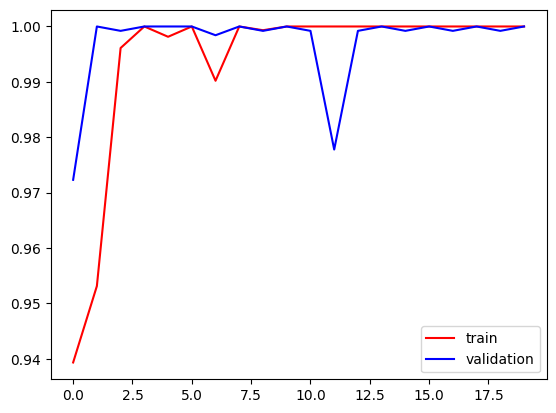

In [ ]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

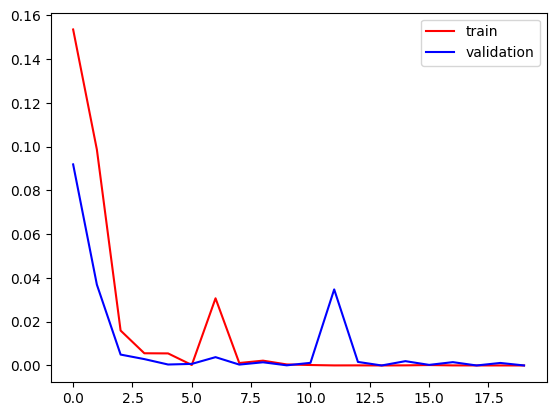

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

REGULARIZED MODEL

In [ ]:
traindatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
valdatagen = ImageDataGenerator(rescale=1./255)

traingentr = traindatagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/train',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

valgentr = valdatagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/val',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    traingentr,
    steps_per_epoch=370,
    epochs=20,
    validation_data=valgentr,
    validation_steps=79,
    callbacks=[earlystop]
)


Found 6109 images belonging to 2 classes.
Found 1309 images belonging to 2 classes.
Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.7904 - loss: 0.7722 - val_accuracy: 0.6377 - val_loss: 5.0832
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8959 - loss: 0.5516 - val_accuracy: 0.5556 - val_loss: 6.1713
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9337 - loss: 0.3545 - val_accuracy: 0.9462 - val_loss: 0.3408
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9534 - loss: 0.3120 - val_accuracy: 0.9778 - val_loss: 0.2304
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9536 - loss: 0.3149 - val_accuracy: 0.9296 - val_loss: 0.4422
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.9528 - loss: 0.2520 - val_accuracy: 0.9333 - val_loss: 0.4690
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9664 - loss: 0.2745 - val_accuracy: 0.9850 - val_loss: 0.2155
Epoch 8/20

PLOTTING ACCURACY AND LOSS GRAPHS

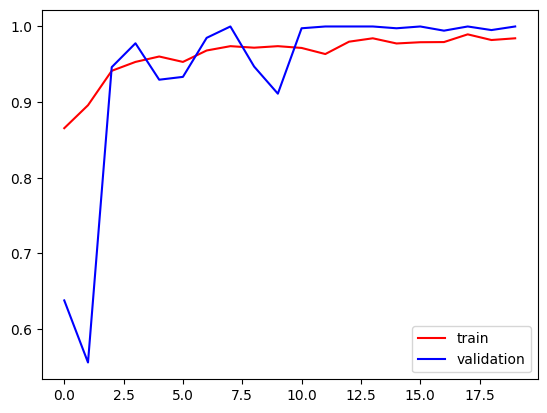

In [ ]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

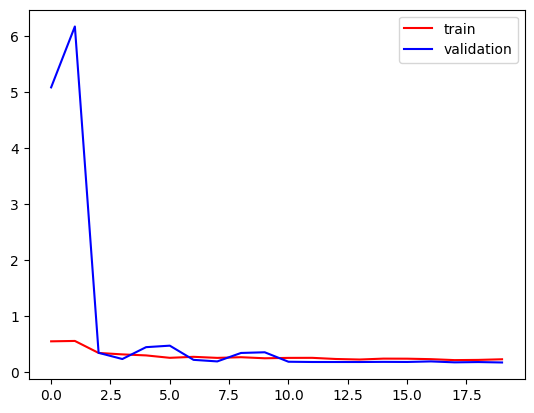

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

TESTING

In [ ]:
testgentr = testdatagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

testloss, testacc = model.evaluate(testgentr, steps=len(testgentr))
print(f"Test Accuracy: {testacc}")

model.save('anti_spoofing_model.h5')

Found 1311 images belonging to 2 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9945 - loss: 0.1826


Test Accuracy: 0.9954233169555664


In [ ]:

def preprocessimg(imgpath):
    img = image.load_img(imgpath, target_size=(64, 64))
    imgarray = image.img_to_array(img)
    imgarray = np.expand_dims(imgarray, axis=0) / 255.0
    return imgarray

def predictimg(imgpath):
    imgarray = preprocessimg(imgpath)
    prediction = model.predict(imgarray)
    if prediction[0][0] > 0.5:
        print(f"{imgpath} is predicted as Real (1)")
    else:
        print(f"{imgpath} is predicted as Fake (0)")

predictimg('/content/Anti-Spoofing-Detector/collected_images/fake/0004/0004_01_00_01_125.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
/content/Anti-Spoofing-Detector/collected_images/fake/0004/0004_01_00_01_125.jpg is predicted as Fake (0)


In [ ]:
predictimg('/content/Anti-Spoofing-Detector/collected_images/real/0007/0007_00_00_01_101.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/Anti-Spoofing-Detector/collected_images/real/0007/0007_00_00_01_101.jpg is predicted as Real (1)


CAPTURING IMAGE FROM WEBCAM

After running the below code,it will ask for camera permissions.Allow it and then re-run the code.

<IPython.core.display.Javascript object>

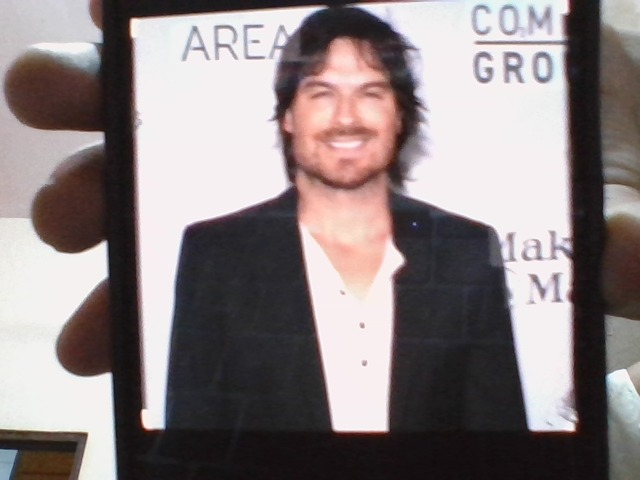

In [ ]:
from google.colab.patches import cv2_imshow
def captimg():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = () => resolve());
            video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            div.remove();
            return canvas.toDataURL('image/jpeg').replace(/^data:image\\/jpeg;base64,/, '');
        }
        ''')
    display(js)
    data = eval_js('takePhoto()')
    img = Image.open(BytesIO(b64decode(data)))
    return img

img = captimg()

img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

cv2.imwrite('captured_image.jpg', img)
cv2_imshow(img)

Detecting face from the captured image using webcam and cropping the face part and saving it as "cropped_face.jpeg"

In [ ]:
def detectfaces(img_path):
    facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = facecascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        bounding_box = {"x": x, "y": y, "w": w, "h": h}
    else:
        bounding_box = None

    return bounding_box

def cropface(img_path, bounding_box):
    img = cv2.imread(img_path)
    if bounding_box:
        x, y, w, h = bounding_box["x"], bounding_box["y"], bounding_box["w"], bounding_box["h"]
        x1, y1 = x, y
        x2, y2 = x + w, y + h

        croppedface = img[y1:y2, x1:x2]

        return croppedface
    else:
        return None

img_path = '/content/Anti-Spoofing-Detector/captured_image.jpg'
bounding_box = detectfaces(img_path)
croppedface = cropface(img_path, bounding_box)

if croppedface is not None:
    output_path = '/content/cropped_face.jpeg'
    cv2.imwrite(output_path, croppedface)
    print(f"Cropped face saved at {output_path}")
else:
    print("No face detected or unable to crop.")



Cropped face saved at /content/cropped_face.jpeg


Testing again on the image captured by webcam

In [ ]:
predictimg('/content/cropped_face.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
/content/cropped_face.jpeg is predicted as Fake (0)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
              precision    recall  f1-score   support

        Fake       0.65      0.64      0.64       831
        Real       0.39      0.39      0.39       480

    accuracy                           0.55      1311
   macro avg       0.52      0.52      0.52      1311
weighted avg       0.55      0.55      0.55      1311



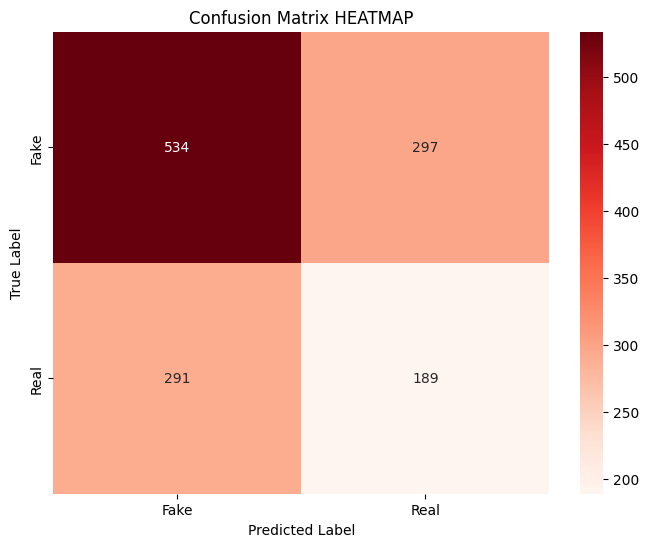

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_labels = testgentr.classes
predictions = model.predict(testgentr, steps=len(testgentr), verbose=1)
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

print(classification_report(test_labels, predicted_labels, target_names=['Fake', 'Real']))

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix HEATMAP')
plt.show()
